In [14]:
import numpy as np 
import pandas as pd 
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats

In [15]:
loan = pd.read_csv('data/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)
loan.info()

/var/folders/bj/1bm8_9hj23n5wy8n37g6dj_w0000gp/T/ipykernel_30381/3897337775.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  loan = pd.read_csv('data/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [16]:
loan.shape

(2260701, 151)

In [17]:
#consider only business critical features
loans = loan[['id', 'loan_amnt', 'term','int_rate', 'sub_grade', 'emp_length','grade', 'annual_inc', 'loan_status', 'dti',
'mths_since_recent_inq', 'revol_util', 'bc_open_to_buy', 'bc_util', 'num_op_rev_tl']]

In [18]:
loans.describe()

,loan_amnt,int_rate,annual_inc,dti,mths_since_recent_inq,revol_util,bc_open_to_buy,bc_util,num_op_rev_tl
count,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,1.965233e+06,2.258866e+06,2.185733e+06,2.184597e+06,2.190392e+06
mean,1.504693e+04,1.309283e+01,7.799243e+04,1.882420e+01,7.024194e+00,5.033770e+01,1.139426e+04,5.789995e+01,8.246523e+00
std,9.190245e+03,4.832138e+00,1.126962e+05,1.418333e+01,5.965411e+00,2.471307e+01,1.659953e+04,2.858347e+01,4.683928e+00
min,5.000000e+02,5.310000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,9.490000e+00,4.600000e+04,1.189000e+01,2.000000e+00,3.150000e+01,1.722000e+03,3.540000e+01,5.000000e+00
50%,1.290000e+04,1.262000e+01,6.500000e+04,1.784000e+01,5.000000e+00,5.030000e+01,5.442000e+03,6.020000e+01,7.000000e+00
75%,2.000000e+04,1.599000e+01,9.300000e+04,2.449000e+01,1.100000e+01,6.940000e+01,1.418700e+04,8.310000e+01,1.000000e+01
max,4.000000e+04,3.099000e+01,1.100000e+08,9.990000e+02,2.500000e+01,8.923000e+02,7.111400e+05,3.396000e+02,9.100000e+01


In [19]:
#preprocessing

#remove missing values
loans = loans.dropna()

#remove outliers
q_low = loans["annual_inc"].quantile(0.08)
q_hi  = loans["annual_inc"].quantile(0.92)
loans = loans[(loans["annual_inc"] < q_hi) & (loans["annual_inc"] > q_low)]
loans = loans[(loans['dti'] <=45)]
q_hi  = loans['bc_open_to_buy'].quantile(0.95)
loans = loans[(loans['bc_open_to_buy'] < q_hi)]
loans = loans[(loans['bc_util'] <=160)]
loans = loans[(loans['revol_util'] <=150)]
loans = loans[(loans['num_op_rev_tl'] <=35)]

#categorical features processing
cleaner_app_type = {"term": {" 36 months": 1.0, " 60 months": 2.0},
                    "sub_grade": {"A1": 1.0, "A2": 2.0, "A3": 3.0, "A4": 4.0, "A5": 5.0,
                                  "B1": 11.0, "B2": 12.0, "B3": 13.0, "B4": 14.0, "B5": 15.0,
                                  "C1": 21.0, "C2": 22.0, "C3": 23.0, "C4": 24.0, "C5": 25.0,
                                  "D1": 31.0, "D2": 32.0, "D3": 33.0, "D4": 34.0, "D5": 35.0,
                                  "E1": 41.0, "E2": 42.0, "E3": 43.0, "E4": 44.0, "E5": 45.0,
                                  "F1": 51.0, "F2": 52.0, "F3": 53.0, "F4": 54.0, "F5": 55.0,
                                  "G1": 61.0, "G2": 62.0, "G3": 63.0, "G4": 64.0, "G5": 65.0,
                                    },
                     "emp_length": {"< 1 year": 0.0, '1 year': 1.0, '2 years': 2.0, '3 years': 3.0, '4 years': 4.0, 
                                   '5 years': 5.0, '6 years': 6.0, '7 years': 7.0, '8 years': 8.0, '9 years': 9.0,
                                   '10+ years': 10.0 }
                   }
loans = loans.replace(cleaner_app_type)

In [20]:
loans = loans.drop('grade', axis=1)

In [21]:
loans['loan_status'].value_counts()

Fully Paid            677985
Current               529702
Charged Off           177323
Late (31-120 days)     14088
In Grace Period         5583
Late (16-30 days)       2743
Default                   23
Name: loan_status, dtype: int64

In [22]:
array = ['Charged Off', 'Fully Paid']
loans = loans.loc[loans['loan_status'].isin(array)]

In [23]:
cleaner_app_type1 = {"loan_status": { "Fully Paid": 1.0, "Charged Off": 0.0}}
loans = loans.replace(cleaner_app_type1)

In [24]:
from sklearn.feature_selection import VarianceThreshold

variance = VarianceThreshold(threshold = (.9 * (1 - .9)))
variance.fit(loans)

variance.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [25]:
loans_cor=loans.corr()
loans_cor

/var/folders/bj/1bm8_9hj23n5wy8n37g6dj_w0000gp/T/ipykernel_30381/4284642248.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loans_cor=loans.corr()


,loan_amnt,term,int_rate,sub_grade,emp_length,annual_inc,loan_status,dti,mths_since_recent_inq,revol_util,bc_open_to_buy,bc_util,num_op_rev_tl
loan_amnt,1.000000,0.397278,0.211851,0.216334,0.056998,0.381464,-0.099605,0.094921,0.023388,0.133704,0.155412,0.086327,0.136805
term,0.397278,1.000000,0.448837,0.465892,0.043918,0.071767,-0.192290,0.089984,-0.021508,0.066395,0.008934,0.053282,0.040339
int_rate,0.211851,0.448837,1.000000,0.971548,0.010474,-0.073835,-0.258134,0.165715,-0.179161,0.210137,-0.260253,0.219355,0.031369
sub_grade,0.216334,0.465892,0.971548,1.000000,0.010256,-0.074905,-0.268379,0.176446,-0.186694,0.213144,-0.268341,0.224586,0.035313
emp_length,0.056998,0.043918,0.010474,0.010256,1.000000,0.084716,0.011104,0.043357,0.004829,0.034749,0.002122,0.033137,0.100101
annual_inc,0.381464,0.071767,-0.073835,-0.074905,0.084716,1.000000,0.047735,-0.166957,-0.043641,0.085840,0.141571,0.036321,0.090483
loan_status,-0.099605,-0.192290,-0.258134,-0.268379,0.011104,0.047735,1.000000,-0.105084,0.059889,-0.052478,0.072511,-0.056164,-0.047156
dti,0.094921,0.089984,0.165715,0.176446,0.043357,-0.166957,-0.105084,1.000000,-0.009696,0.184675,-0.035349,0.185649,0.208789
mths_since_recent_inq,0.023388,-0.021508,-0.179161,-0.186694,0.004829,-0.043641,0.059889,-0.009696,1.000000,0.101606,-0.011960,0.087155,-0.090203
revol_util,0.133704,0.066395,0.210137,0.213144,0.034749,0.085840,-0.052478,0.184675,0.101606,1.000000,-0.520591,0.839585,-0.172055


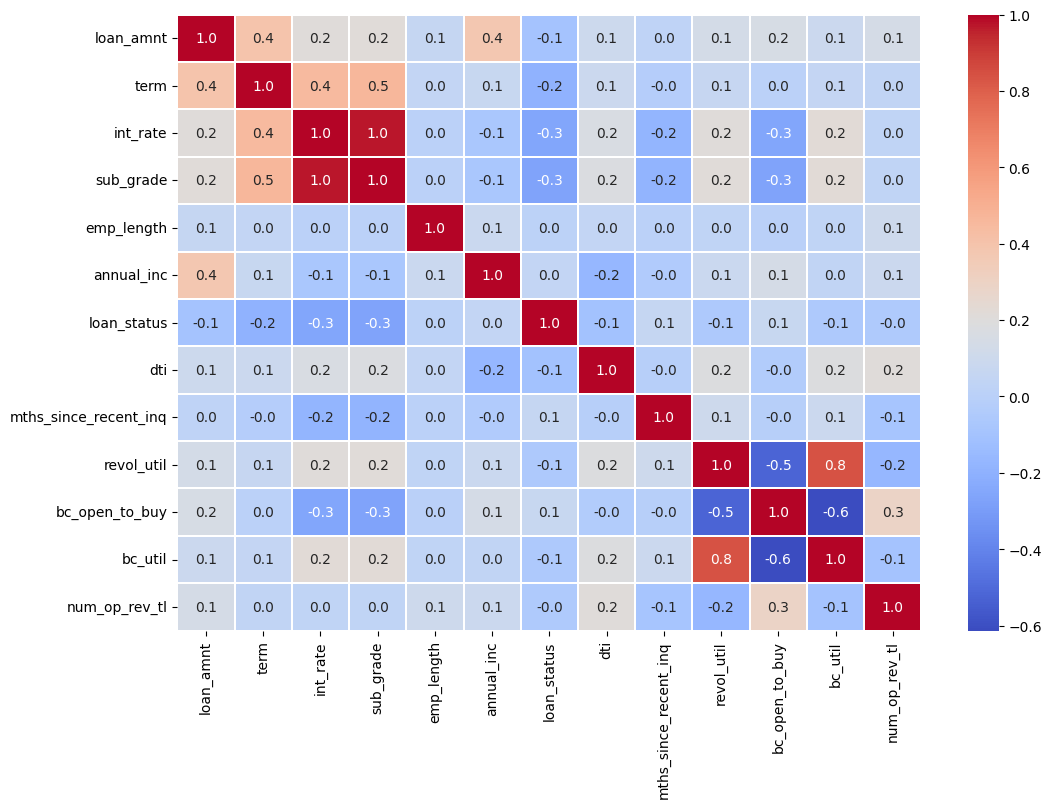

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(loans_cor, cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.show()

In [27]:
loans['loan_status'].value_counts()

1.0    677985
0.0    177323
Name: loan_status, dtype: int64

In [28]:

loans = loans.drop('id', axis=1)

In [29]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

X = loans.drop('loan_status', axis=1)
y = loans[['loan_status']]
y = y.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Next step is we are going to use SequentialFeatureSelector to find the "best" features:

In [30]:
#importing the necessary libraries
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(),
          k_features='best',
          forward=True,
          floating=False,
          scoring = 'precision',
          cv = 0)

and we need to fit the above code to define feature selector on our loan dataset:

In [31]:
sfs.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

SequentialFeatureSelector(cv=0, estimator=LogisticRegression(),
                          k_features=(1, 12), scoring='precision')

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline

sc = MinMaxScaler()
clf = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')

pipe_lr = Pipeline([('scaler', sc), ('clf', clf)])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_train, y_train)

0.7934576394312536

In [33]:

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score


model = KMeans(n_clusters=2, random_state=0)

model.fit(X_train)

predictions = model.predict(X_test)
print('accuracy ', accuracy_score(y_test, predictions))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


accuracy  0.29460732274221685


We can see the selection process by comparing performance vs. the number of features in each training step. In addition, we can see that the chosem model metric does not change drastically during iteration steps.

In [35]:
from sklearn import neighbors, metrics

knn = neighbors.KNeighborsClassifier(n_neighbors=30, weights='uniform')
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
accuracy = metrics.accuracy_score(y_test, predictions)
print('Accuracy ', accuracy)

Accuracy  0.7903164707918083


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


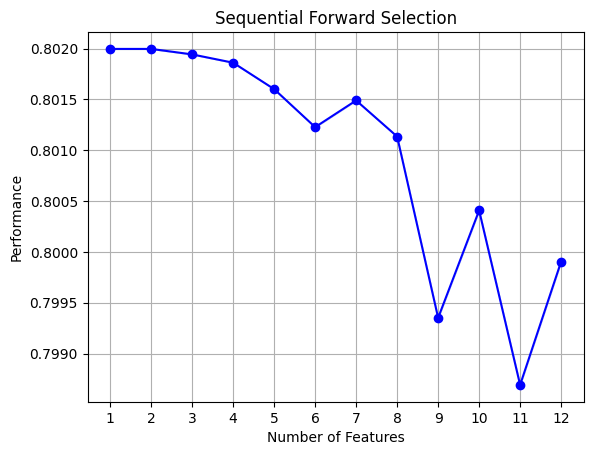

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()